In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import IPython

from preprocessing import get_spectrogram
from preprocessing import get_audio_and_label

from sklearn.model_selection import ParameterGrid

from glob import glob
from time import time
import os
import csv

2023-02-22 14:14:00.270291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 14:14:00.392255: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-22 14:14:00.397539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-22 14:14:00.397558: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
# Comment the following line after the first run
# !unzip -q /work/Mini-CREMA.zip

In [3]:
!ls Mini-CREMA/ | wc -l

3


In [4]:
!ls Mini-CREMA/ | head -n5

test
train
val


## Here you can listen to some audios if you change the name of the file

In [2]:
filename = 'Mini-CREMA/test/1002_TSI_NEU_XX.wav'

In [3]:
audio_binary = tf.io.read_file(filename)
audio, sampling_rate = tf.audio.decode_wav(audio_binary)


path_parts = tf.strings.split(filename, '/')
# print(path_parts)
path_end = path_parts[-1]
# print(path_end)
file_parts = tf.strings.split(path_end, '_')
label = file_parts[-2]


print('Label:', label.numpy().decode())
print('Audio shape:', audio.shape)
print('Sampling rate:', sampling_rate)

IPython.display.Audio(filename=filename, rate=sampling_rate)

Label: NEU
Audio shape: (37904, 1)
Sampling rate: tf.Tensor(16000, shape=(), dtype=int32)
2023-02-22 14:15:22.069842: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-22 14:15:22.069881: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-22 14:15:22.069897: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-852612cc-cd86-4ccb-b1bb-30f77a7cea74): /proc/driver/nvidia/version does not exist
2023-02-22 14:15:22.070261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [5]:
filename = 'Mini-CREMA/test/1002_IOM_ANG_XX.wav'

In [6]:
audio_binary = tf.io.read_file(filename)
audio, sampling_rate = tf.audio.decode_wav(audio_binary)


path_parts = tf.strings.split(filename, '/')
# print(path_parts)
path_end = path_parts[-1]
# print(path_end)
file_parts = tf.strings.split(path_end, '_')
label = file_parts[-2]


print('Label:', label.numpy().decode())
print('Audio shape:', audio.shape)
print('Sampling rate:', sampling_rate)

IPython.display.Audio(filename=filename, rate=sampling_rate)

Label: ANG
Audio shape: (45379, 1)
Sampling rate: tf.Tensor(16000, shape=(), dtype=int32)
2023-02-22 07:58:06.557602: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-22 07:58:06.557643: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-22 07:58:06.557661: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-852612cc-cd86-4ccb-b1bb-30f77a7cea74): /proc/driver/nvidia/version does not exist
2023-02-22 07:58:06.558007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [7]:
audio_8k = tfio.audio.resample(audio, sampling_rate.numpy(), 8000)

print('Resampled Audio shape:', audio_8k.shape) #this cut in half the dimension of the audio file


2023-02-22 07:58:06.718396: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2023-02-22 07:58:06.718614: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA
Resampled Audio shape: (22689, 1)


### We have to understand how to capture the majority of audio and have all the files equal

reference min 28 https://www.youtube.com/watch?v=ZLIPkmmDJAc&t=1245s

When training a deep neural network for audio classification, it is usually better to take shorter segments of the full audio rather than resampling the entire audio to a lower sampling rate.

There are several reasons for this:

Memory and computational requirements: Deep neural networks require a large amount of memory and computational resources to train. By taking shorter segments of the full audio, you can reduce the amount of memory and computation required, allowing you to train larger models and perform more experiments in less time.

Training data diversity: By taking shorter segments of the full audio, you can increase the diversity of the training data. This is because different segments of the same audio may have different characteristics, such as the presence or absence of certain sounds or noise. By including multiple segments of the same audio in the training data, you can improve the generalization performance of the model.

Real-time processing: In many applications, such as speech recognition or audio surveillance, the audio data is processed in real time. By taking shorter segments of the full audio, you can process the audio in real time, rather than waiting for the entire audio to be processed before making a prediction.

That being said, the choice of segment length depends on the specific task and the characteristics of the audio data. In general, segment lengths of 1-10 seconds are common for audio classification tasks 

In [8]:
dir1 = 'Mini-CREMA/train'
dir2 = 'Mini-CREMA/test'
dir3 = 'Mini-CREMA/val'

file_list = []

for directory in [dir1, dir2, dir3]:
    for filename in os.listdir(directory):
        file_list.append(os.path.join(directory, filename))

print(len(file_list))

3629


In [9]:
lengths = []
sampling_freq_set = set()
max_audio = 0
name_max_audio = ''
min_audio = 100000000000
name_min_audio = ''

for file_name in file_list:
    audio_binary = tf.io.read_file(file_name)
    audio, sampling_rate = tf.audio.decode_wav(audio_binary)
    lengths.append(audio.shape[0])
    if(audio.shape[0]>max_audio):
        max_audio = audio.shape[0]
        name_max_audio = file_name

    if(audio.shape[0]<min_audio):
        min_audio = audio.shape[0]
        name_min_audio = file_name

    sampling_freq_set.add(sampling_rate.numpy())

print(len(lengths))
print(sampling_freq_set)

3629
{16000}


In [10]:
print(f'Max audio name is {name_max_audio} and has length {max_audio}')
IPython.display.Audio(filename=name_max_audio, rate=sampling_rate)

Max audio name is Mini-CREMA/test/1008_TIE_ANG_XX.wav and has length 79546


In [11]:
print(f'Min audio name is {name_min_audio} and has length {min_audio}')
IPython.display.Audio(filename=name_min_audio, rate=sampling_rate)

Min audio name is Mini-CREMA/train/1075_IEO_HAP_HI.wav and has length 21355


In [12]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=39255>

In [13]:
print("The average length of audios is:")
print(39255/16000)

The average length of audios is:
2.4534375


In [14]:
print("The min and max of audios are:")
print(tf.math.reduce_min(lengths))
print('the min length in seconds is: ', 21355/16000)
print(tf.math.reduce_max(lengths))
print('the max length in seconds is: ', 79546/16000)

The min and max of audios are:
tf.Tensor(21355, shape=(), dtype=int32)
the min length in seconds is:  1.3346875
tf.Tensor(79546, shape=(), dtype=int32)
the max length in seconds is:  4.971625


In [15]:
def get_audio_and_label(filename):
    sample_points = 48000
    audio_binary = tf.io.read_file(filename)
    audio, sampling_rate = tf.audio.decode_wav(audio_binary) 

    path_parts = tf.strings.split(filename, '/')
    # print(path_parts)
    path_end = path_parts[-1]
    # print(path_end)
    file_parts = tf.strings.split(path_end, '_')
    label = file_parts[-2]
    
    audio = tf.squeeze(audio)
    audio = audio[:sample_points]
    print(audio.shape)
    zero_padding = tf.zeros(sample_points - tf.shape(audio), dtype=tf.float32)
    audio_padded = tf.concat([audio, zero_padding], axis=0)
    audio = audio_padded

    return audio, sampling_rate, label

In [16]:
filename = 'Mini-CREMA/test/1002_IOM_ANG_XX.wav'
# longest audio clip Mini-CREMA/test/1008_TIE_ANG_XX.wav also works
audio, sampling_rate, label = get_audio_and_label(filename)
audio,sampling_rate, label

(45379,)


(<tf.Tensor: shape=(48000,), dtype=float32, numpy=
 array([-2.7465820e-04,  3.0517578e-05,  5.1879883e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int32, numpy=16000>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'ANG'>)

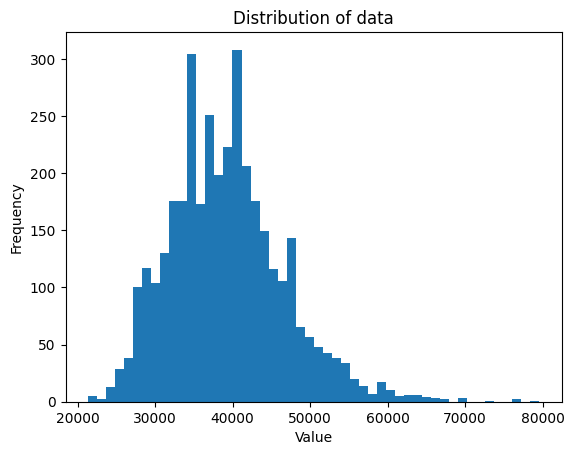

In [17]:
plt.hist(lengths, bins=50)
plt.title("Distribution of data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


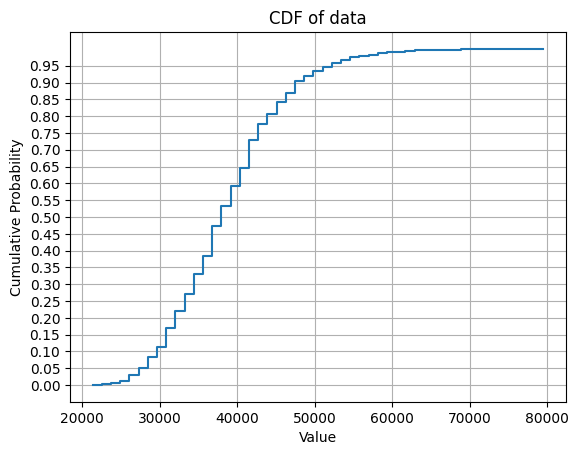

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

data =lengths

ecdf = ECDF(data)
x = np.linspace(min(data), max(data))
y = ecdf(x)

plt.step(x, y)
plt.title("CDF of data")
plt.xlabel("Value")
plt.ylabel("Cumulative Probability")
plt.grid(True)
plt.yticks(np.arange(0, 1, 0.05))
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f648dc53-4e62-47c1-9023-194409755340' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>